In [6]:
!pip install GEOparse
!pip install gseapy

In [7]:
# Core scientific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# GEO dataset handling
import GEOparse

# Preprocessing & ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
)

# Dimensionality reduction
from sklearn.decomposition import PCA

# Pathway enrichment
import gseapy as gp

# Plotting style
sns.set(style="whitegrid")

# Initialize plots directory
PLOTS_DIR = Path("../plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
for subdir in ["pca", "roc", "confusion", "heatmaps", "feature_importance"]:
    (PLOTS_DIR / subdir).mkdir(exist_ok=True)

In [8]:
def save_fig(name: str, subfolder: str = "", ext: str = "png", dpi: int = 300, close: bool = False) -> Path:
    """
    Save the current matplotlib figure to plots/ directory with timestamp.
    
    Args:
        name: Descriptive name for the plot (e.g., 'pca_top_selected')
        subfolder: Optional subfolder within plots/ (e.g., 'pca', 'roc')
        ext: File extension ('png', 'svg', 'pdf')
        dpi: Resolution for raster formats
        close: Whether to close the figure after saving
    
    Returns:
        Path to saved file
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{timestamp}_{name}.{ext}"
    
    if subfolder:
        save_path = PLOTS_DIR / subfolder / filename
    else:
        save_path = PLOTS_DIR / filename
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    print(f"📊 Saved: {save_path}")
    
    if close:
        plt.close()
    
    return save_path

In [9]:
def extract_labels(gsm):
    """Extract cancer vs normal labels from GSM metadata."""
    fields = [
        gsm.metadata.get("title", ""),
        gsm.metadata.get("source_name_ch1", ""),
        gsm.metadata.get("characteristics_ch1", "")
    ]
    txt = " ".join(map(str, fields)).lower()

    if "normal" in txt or "control" in txt:
        return "normal"
    if "cancer" in txt or "tumor" in txt:
        return "cancer"
    return "unknown"


print("Loading GSE15852...")
gse = GEOparse.get_GEO("GSE15852", destdir="../geo_raw", silent=True)

# Build probe-level matrix
expr_dict = {}
for gsm_id, gsm in gse.gsms.items():
    tbl = gsm.table.copy()
    probe_col = "ID_REF" if "ID_REF" in tbl.columns else tbl.columns[0]
    val_col = "VALUE" if "VALUE" in tbl.columns else tbl.columns[-1]

    series = (
        tbl[[probe_col, val_col]]
        .dropna()
        .set_index(probe_col)[val_col]
        .astype(float)
    )
    expr_dict[gsm_id] = series

X_probe = pd.DataFrame(expr_dict).T
X_probe.index.name = "sample"
print("Probe matrix:", X_probe.shape)

# Extract labels
labels = pd.Series({gsm_id: extract_labels(gsm) for gsm_id, gsm in gse.gsms.items()},
                   name="label")

print("Labels before filtering:")
print(labels.value_counts())

# Keep only normal/cancer
mask = labels.isin(["normal", "cancer"])
labels = labels[mask]
X_probe = X_probe.loc[labels.index]

print("\nLabels after filtering:")
print(labels.value_counts())
print("Filtered matrix:", X_probe.shape)

Loading GSE15852...
Probe matrix: (86, 22283)
Labels before filtering:
label
normal    43
cancer    43
Name: count, dtype: int64

Labels after filtering:
label
normal    43
cancer    43
Name: count, dtype: int64
Filtered matrix: (86, 22283)
Probe matrix: (86, 22283)
Labels before filtering:
label
normal    43
cancer    43
Name: count, dtype: int64

Labels after filtering:
label
normal    43
cancer    43
Name: count, dtype: int64
Filtered matrix: (86, 22283)


In [10]:
print("Loading GPL96 annotation...")
gpl = GEOparse.get_GEO("GPL96", destdir="../geo_raw", silent=True)

ann = gpl.table.copy()
ann.columns = ann.columns.str.upper()

# Identify gene symbol column
symbol_candidates = ["GENE SYMBOL", "GENE_SYMBOL", "GENE SYMBOLS", "SYMBOL", "GENE"]
symbol_col = next((c for c in symbol_candidates if c in ann.columns), None)

if symbol_col is None:
    raise ValueError("Gene symbol column not found in GPL96 annotation.")

# Clean annotation table
ann = ann[["ID", symbol_col]].rename(columns={symbol_col: "GENE"})
ann["GENE"] = ann["GENE"].astype(str).str.split("///").str[0].str.strip()
ann = ann[ann["GENE"] != ""]

# Match probes
common = X_probe.columns.intersection(ann["ID"])
ann = ann.set_index("ID").loc[common]

expr = X_probe[common].copy()
expr.columns = ann["GENE"]

# Collapse multiple probes → same gene
X_gene = expr.groupby(expr.columns, axis=1).mean()

y = labels.copy()
print("Gene matrix:", X_gene.shape)

Loading GPL96 annotation...
Gene matrix: (86, 13238)
Gene matrix: (86, 13238)


/var/folders/t5/f7h8xdc15fv4wlpvsmrs4j2r0000gn/T/ipykernel_26762/3500068322.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_gene = expr.groupby(expr.columns, axis=1).mean()


In [11]:
# Label encoding
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_gene, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# Log transform + scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(np.log1p(X_train))
X_test = scaler.transform(np.log1p(X_test))

# Oversampling (simple random oversampling)
counts = np.bincount(y_train)
maj, minc = np.argmax(counts), 1 - np.argmax(counts)
n_extra = counts[maj] - counts[minc]

idx_min = np.where(y_train == minc)[0]
idx_add = np.random.choice(idx_min, n_extra, replace=True)

X_train_bal = np.vstack([X_train, X_train[idx_add]])
y_train_bal = np.concatenate([y_train, y_train[idx_add]])

# ------------------- Random Forest ------------------- #
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_bal, y_train_bal)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, rf_pred, target_names=le.classes_))
print("AUC:", roc_auc_score(y_test, rf_proba))

# ------------------- MLP Neural Network ------------------- #
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=300,
    early_stopping=True,
    random_state=42,
)

mlp.fit(X_train_bal, y_train_bal)
mlp_pred = mlp.predict(X_test)
mlp_proba = mlp.predict_proba(X_test)[:, 1]

print("\n=== MLP ===")
print(classification_report(y_test, mlp_pred, target_names=le.classes_))
print("AUC:", roc_auc_score(y_test, mlp_proba))

=== Random Forest ===
              precision    recall  f1-score   support

      cancer       0.71      0.91      0.80        11
      normal       0.88      0.64      0.74        11

    accuracy                           0.77        22
   macro avg       0.79      0.77      0.77        22
weighted avg       0.79      0.77      0.77        22

AUC: 0.8512396694214877

=== MLP ===
              precision    recall  f1-score   support

      cancer       0.90      0.82      0.86        11
      normal       0.83      0.91      0.87        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22

AUC: 0.9090909090909091

=== MLP ===
              precision    recall  f1-score   support

      cancer       0.90      0.82      0.86        11
      normal       0.83      0.91      0.87        11

    accuracy                           0.86        22
   macro avg       0.87      0.8

In [12]:
print("Initial genes:", X_gene.shape[1])

# Remove zero-variance genes
var_sel = VarianceThreshold()
X_var = var_sel.fit_transform(X_gene)
print("After variance filter:", X_var.shape)

# ANOVA F-test selection
K = 500
anova_sel = SelectKBest(f_classif, k=K)
X_selected = anova_sel.fit_transform(X_var, y_enc)
print("After ANOVA:", X_selected.shape)

Initial genes: 13238
After variance filter: (86, 13238)
After ANOVA: (86, 500)


In [13]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=10, class_weight="balanced", random_state=42),
    "SVM-RBF": SVC(kernel="rbf", C=2, probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05,
                                 subsample=0.8, colsample_bytree=0.8, eval_metric="logloss")
}

for name, model in models.items():
    scores = cross_val_score(model, X_selected, y_enc, cv=skf, scoring="roc_auc")
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

RandomForest: 0.9600 ± 0.0386
SVM-RBF: 0.9613 ± 0.0342
MLP: 0.9125 ± 0.0782
MLP: 0.9125 ± 0.0782
XGBoost: 0.9425 ± 0.0472
XGBoost: 0.9425 ± 0.0472


In [14]:
# SVM
svm = SVC(kernel="rbf", C=2, probability=True, random_state=42)
svm.fit(X_train_bal, y_train_bal)

svm_pred = svm.predict(X_test)
svm_proba = svm.predict_proba(X_test)[:, 1]

print("=== SVM ===")
print(classification_report(y_test, svm_pred, target_names=le.classes_))
print("AUC:", roc_auc_score(y_test, svm_proba))

# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

xgb_clf.fit(X_train_bal, y_train_bal)

xgb_pred = xgb_clf.predict(X_test)
xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]

print("\n=== XGBoost ===")
print(classification_report(y_test, xgb_pred, target_names=le.classes_))
print("AUC:", roc_auc_score(y_test, xgb_proba))

=== SVM ===
              precision    recall  f1-score   support

      cancer       0.71      0.91      0.80        11
      normal       0.88      0.64      0.74        11

    accuracy                           0.77        22
   macro avg       0.79      0.77      0.77        22
weighted avg       0.79      0.77      0.77        22

AUC: 0.8677685950413223

=== XGBoost ===
              precision    recall  f1-score   support

      cancer       0.77      0.91      0.83        11
      normal       0.89      0.73      0.80        11

    accuracy                           0.82        22
   macro avg       0.83      0.82      0.82        22
weighted avg       0.83      0.82      0.82        22

AUC: 0.9008264462809917

=== XGBoost ===
              precision    recall  f1-score   support

      cancer       0.77      0.91      0.83        11
      normal       0.89      0.73      0.80        11

    accuracy                           0.82        22
   macro avg       0.83      0.82 

📊 Saved: ../plots/pca/20251130_021609_pca_top_selected_genes.png


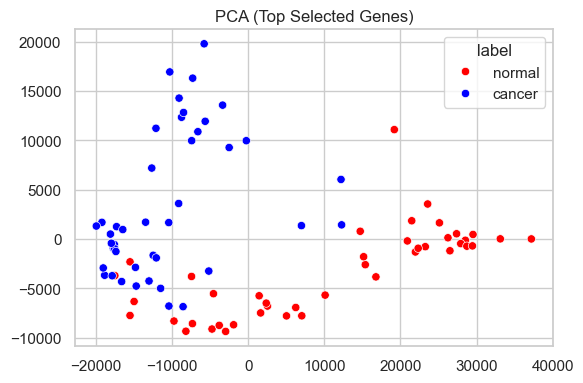

📊 Saved: ../plots/heatmaps/20251130_021610_correlation_top50_genes.png


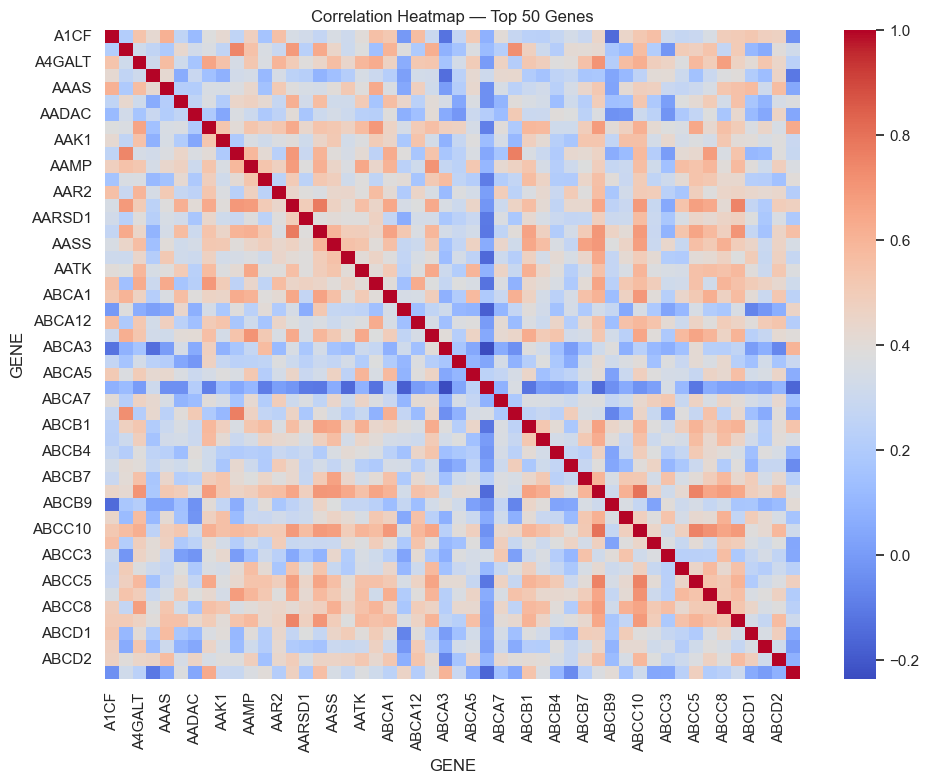

In [15]:
# PCA on selected features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(6,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette=["red", "blue"])
plt.title("PCA (Top Selected Genes)")
save_fig("pca_top_selected_genes", subfolder="pca")
plt.show()

# Gene-gene correlation (top 50)
top_corr = X_gene.iloc[:, :50].corr()

plt.figure(figsize=(10,8))
sns.heatmap(top_corr, cmap="coolwarm")
plt.title("Correlation Heatmap — Top 50 Genes")
save_fig("correlation_top50_genes", subfolder="heatmaps")
plt.show()

In [16]:
# Compute top RF genes if necessary
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:100]
top_genes = X_gene.columns[idx]

# Enrichment using Enrichr
enrich = gp.enrichr(
    gene_list=list(top_genes),
    gene_sets=["KEGG_2021_Human", "GO_Biological_Process_2021"],
    organism="Human",
    cutoff=0.05
)

display(enrich.results.head(20))
enrich.results.to_csv("../results/pathway_enrichment_results.csv", index=False)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,negative regulation of cell-cell adhesion (GO:...,6/41,5.238947e-08,0.000068,0,0,36.227964,607.345876,RGCC;CDH1;EPCAM;ADIPOQ;SPINT2;ASS1
1,GO_Biological_Process_2021,positive regulation of cell differentiation (G...,10/258,6.701670e-07,0.000437,0,0,8.804659,125.164740,TMEM100;RGCC;RARRES2;IGFBP3;TACSTD2;LPL;TWIST1...
2,GO_Biological_Process_2021,positive regulation of multicellular organisma...,11/345,1.236768e-06,0.000516,0,0,7.240328,98.490254,RGCC;ACSL1;LEP;ADIPOQ;SAA1;TWIST1;G0S2;CD36;HA...
3,GO_Biological_Process_2021,positive regulation of metabolic process (GO:0...,7/113,1.582148e-06,0.000516,0,0,14.055386,187.733961,ACSL1;LEP;ADIPOQ;G0S2;CD36;HADH;ACACB
4,GO_Biological_Process_2021,regulation of fat cell differentiation (GO:004...,6/80,2.992371e-06,0.000717,0,0,17.101208,217.517861,RARRES2;LEP;ADIPOQ;ADIRF;LPL;PPARG
5,GO_Biological_Process_2021,hydrogen peroxide catabolic process (GO:0042744),4/21,3.298301e-06,0.000717,0,0,48.732843,615.110972,GPX3;HBG1;CAT;HBB
6,GO_Biological_Process_2021,positive regulation of cold-induced thermogene...,6/97,9.189764e-06,0.001713,0,0,13.894552,161.140963,ACSL1;LEP;ADIPOQ;G0S2;CD36;HADH
7,GO_Biological_Process_2021,hydrogen peroxide metabolic process (GO:0042743),4/29,1.269340e-05,0.002071,0,0,33.125000,373.465453,GPX3;HBG1;CAT;HBB
8,GO_Biological_Process_2021,positive regulation of protein kinase B signal...,7/161,1.642919e-05,0.002178,0,0,9.651026,106.320057,ANGPT1;LEP;AKR1C3;AKR1C2;ITGB1BP1;GAB2;RTN4
9,GO_Biological_Process_2021,regulation of macrophage derived foam cell dif...,4/31,1.668756e-05,0.002178,0,0,30.668210,337.376293,ADIPOQ;LPL;PPARG;CD36


In [17]:
comparison = pd.DataFrame({
    "Random Forest": [roc_auc_score(y_test, rf_proba)],
    "MLP": [roc_auc_score(y_test, mlp_proba)],
    "SVM": [roc_auc_score(y_test, svm_proba)],
    "XGBoost": [roc_auc_score(y_test, xgb_proba)]
}).T.rename(columns={0: "AUC"})

comparison.sort_values("AUC", ascending=False)

,AUC
MLP,0.909091
XGBoost,0.900826
SVM,0.867769
Random Forest,0.851240


📊 Saved: ../plots/roc/20251130_021611_roc_comparison_rf_mlp.png


<Figure size 600x600 with 0 Axes>

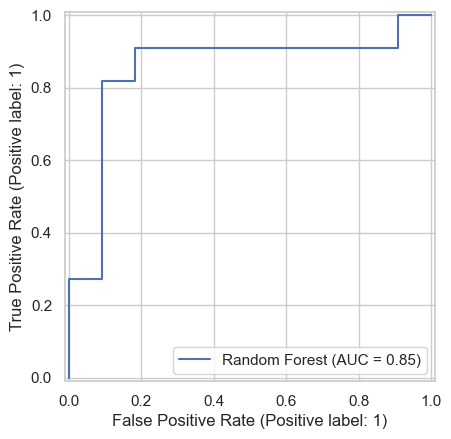

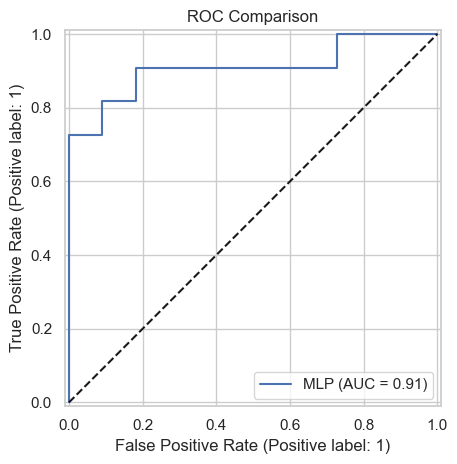

/var/folders/t5/f7h8xdc15fv4wlpvsmrs4j2r0000gn/T/ipykernel_26762/2371564595.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


📊 Saved: ../plots/feature_importance/20251130_021612_rf_top20_genes.png


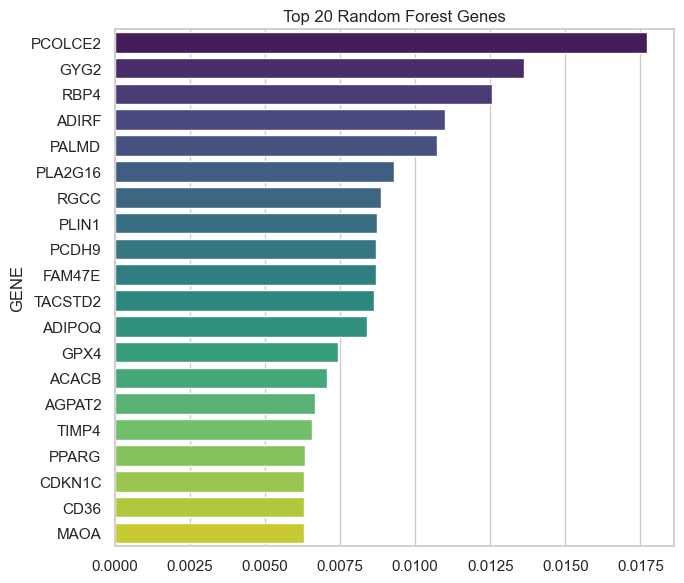

📊 Saved: ../plots/pca/20251130_021612_pca_full_gene_matrix.png


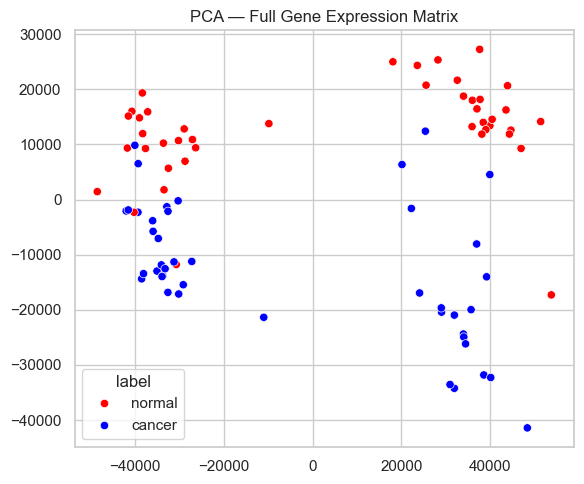

In [18]:
# ROC curves
plt.figure(figsize=(6,6))
RocCurveDisplay.from_predictions(y_test, rf_proba, name="Random Forest")
RocCurveDisplay.from_predictions(y_test, mlp_proba, name="MLP")
plt.plot([0,1], [0,1], "k--")
plt.title("ROC Comparison")
save_fig("roc_comparison_rf_mlp", subfolder="roc")
plt.show()

# Top 20 genes (RF)
idx = np.argsort(rf.feature_importances_)[::-1][:20]
plt.figure(figsize=(7,6))
sns.barplot(
    x=rf.feature_importances_[idx],
    y=X_gene.columns[idx],
    palette="viridis"
)
plt.title("Top 20 Random Forest Genes")
save_fig("rf_top20_genes", subfolder="feature_importance")
plt.show()

# PCA on full gene set
pca_full = PCA(n_components=2)
X_pca_full = pca_full.fit_transform(X_gene)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca_full[:,0], y=X_pca_full[:,1], hue=y, palette=["red", "blue"])
plt.title("PCA — Full Gene Expression Matrix")
save_fig("pca_full_gene_matrix", subfolder="pca")
plt.show()

📊 Saved: ../plots/roc/20251130_021613_roc_all_models_comparison.png


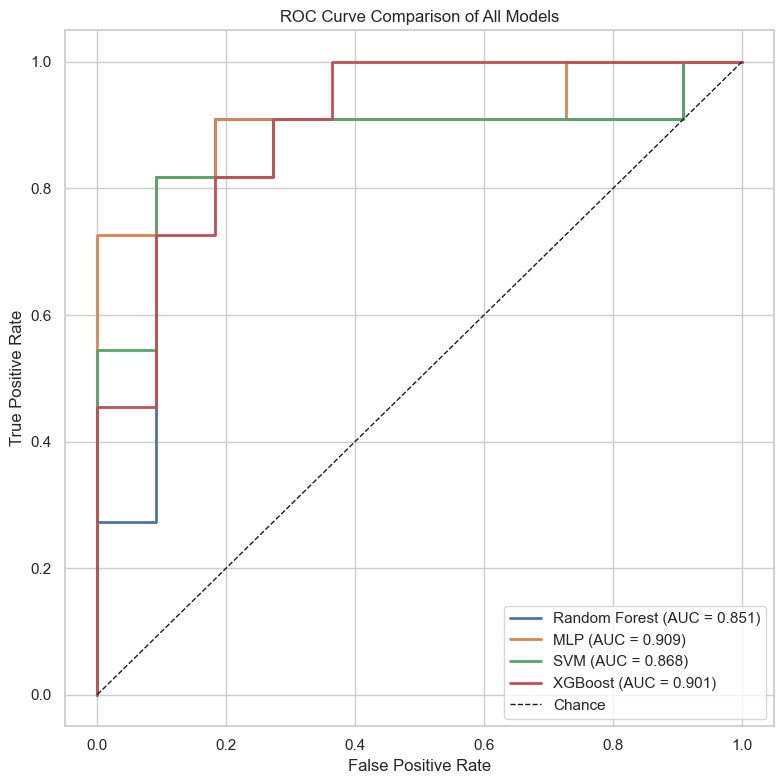

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC & AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_proba)
auc_mlp = auc(fpr_mlp, tpr_mlp)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_proba)
auc_svm = auc(fpr_svm, tpr_svm)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(8,8))

plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.3f})", linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.3f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})", linewidth=2)

# Chance line
plt.plot([0,1], [0,1], "k--", label="Chance", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of All Models")
plt.legend(loc="lower right")
plt.grid(True)
save_fig("roc_all_models_comparison", subfolder="roc")
plt.show()

📊 Saved: ../plots/confusion/20251130_021613_confusion_matrices_all_models.png


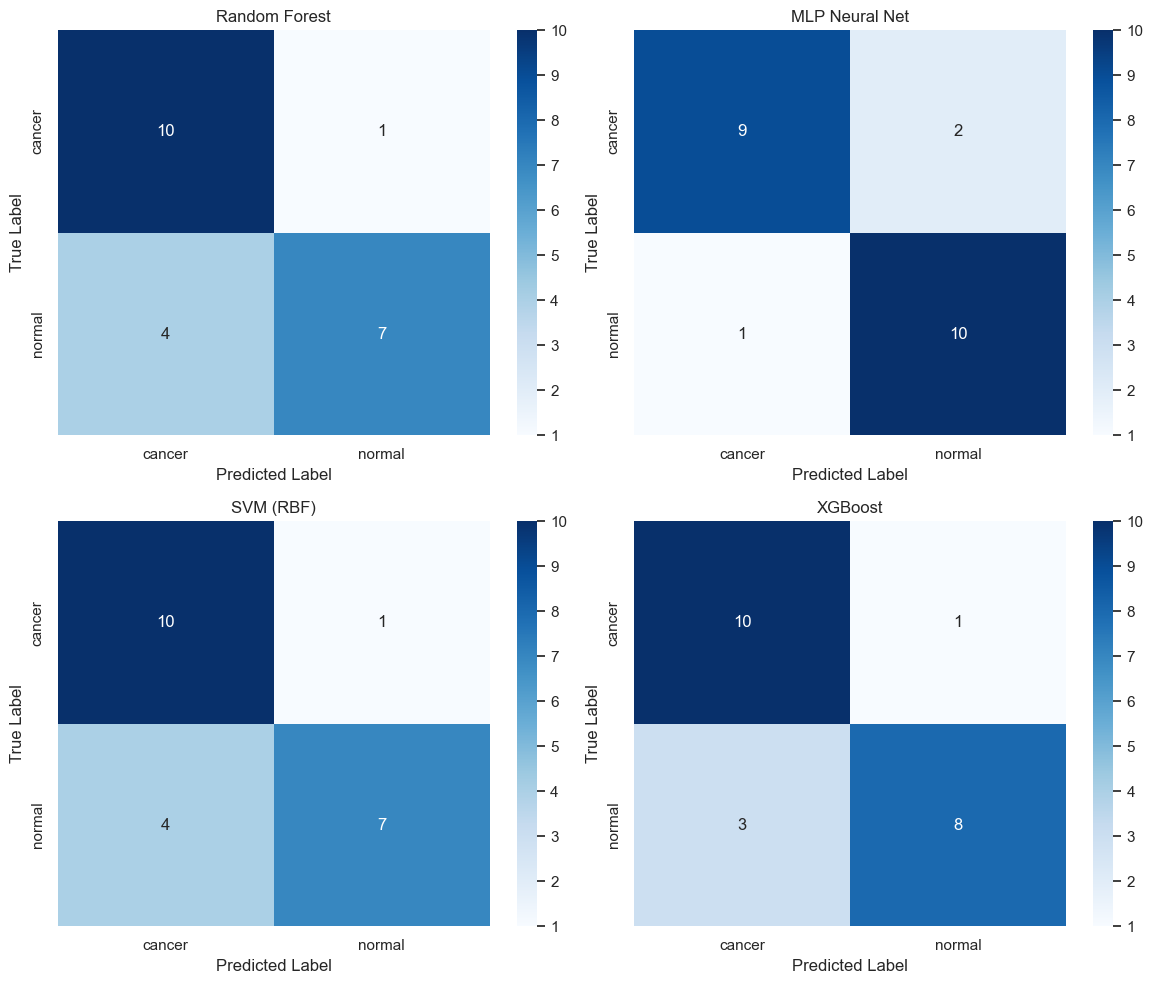

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions (already computed earlier)
# rf_pred, mlp_pred, svm_pred, xgb_pred

models = {
    "Random Forest": rf_pred,
    "MLP Neural Net": mlp_pred,
    "SVM (RBF)": svm_pred,
    "XGBoost": xgb_pred
}

plt.figure(figsize=(12, 10))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(name)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plt.tight_layout()
save_fig("confusion_matrices_all_models", subfolder="confusion")
plt.show()